Some new ideas...

Let's start with independent sets. An independent set is a binary vector $x$, such that $x^TAx=0$, where $A$ is the adjacency matrix. Finding the independence number means maximizing the weight of $x$. Can we phrase this as an optimization problem? Trying to minimize $x^TAx$ is not a problem, since $A$ is a psd matrix. However, without additional constraints, this would just lead to $x=0$, which is clearly not optimal. 

What if we fix the size of the independent set, $K$? Then we are looking for vectors that have a fixed norm (either L1 or L2). Let's further restrict all of our values to lie between 0 and 1. If we fix $|x|$, then forcing $x$ to be binary corresponds to minimizing $|x|_1$ (I think). 

Proof: Suppose $|x|=\sqrt{K}$. Note that since $x\in[0,1]^N$, we have $1-x\ge 0$, and so $x\cdot(1-x)\ge 0$. Therfore, $|x|_1=x\cdot 1\ge x\cdot x=|x|^2=K$. Further, equality holds exactly when $x$ is binary, in which case $|x|_1=K$. 

Therefore, if there is an independent set of size $K$, we should be able to find it be minimizing $x^TAx+|x|_1$ with the constraint $|x|=\sqrt{K}$, $x\in[0,1]^N$. 

In [2]:
import numpy as np 
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class energyModel(torch.nn.Module):
    def __init__(self, A, lam=1.0):
        super(energyModel, self).__init__()
        self.A = A
        self.lam = lam

    def forward(self, x):
        energy = x.t()@self.A@x+self.lam*torch.norm(x,1)
        return energy

In [145]:
# import sys
# sys.path.insert(1, '../OldStuff')
# from GraphFun import *

K = torch.tensor(4.0) # Size of independent set

# Petersen graph adjacency array
A = np.array([
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0]])

# G = genJohnsonGraph(4,2,1)
# A = getAdjArray(G)
# print(A)

# A=np.array([[0, 1, 1, 1, 1, 0], # Octahedron
#        [1, 0, 1, 1, 0, 1],
#        [1, 1, 0, 0, 1, 1],
#        [1, 1, 0, 0, 1, 1],
#        [1, 0, 1, 1, 0, 1],
#        [0, 1, 1, 1, 1, 0]])

# A = np.load("Jvki_graphs/J_10_4.npy")
# A = torch.tensor(A,dtype=torch.float32)
# N = A.shape[0] # Number of vertices

# Init x
x = torch.randn(N,requires_grad=True)
x.data = torch.abs(x.data)
x.data = torch.clamp(x.data,0,1) # Project x to [0,1]
x.data = x.data*torch.sqrt(K)/torch.norm(x.data,2) # Normalize x

# Create model / optimizer
model = energyModel(A)
optimizer = torch.optim.Adam([x], lr=0.001)

# Minimize energy of x
for i in range(5000):
    optimizer.zero_grad()
    energy = model(x)
    energy.backward()
    optimizer.step()
    x.data = torch.clamp(x.data,0,1) # Project x to [0,1]
    x.data = x.data*torch.sqrt(K)/torch.norm(x.data,2) # Normalize x
    x.data = torch.clamp(x.data,0,1)
    if i%1000==0:
        print("L1: ",torch.norm(x,1).item())
        print("Independence: ",(x.t()@A@x).item())
        # print("Energy: ",energy)
        print("")
        # print(x)


L1:  25.566421508789062
Independence:  74.85324096679688

L1:  11.855396270751953
Independence:  8.449209213256836

L1:  6.857504844665527
Independence:  0.08543948829174042

L1:  5.118616580963135
Independence:  0.0

L1:  4.3925251960754395
Independence:  0.0



It seems like this isn't really work. At least it's not working well. Even if we set $\lambda=0$, it can still fail to find the optimum. I'm guessing this is being the L2 norm constraint makes the optimization non-convex. 

Another idea I want to explore is using symmetric polynomials to try to find colorings. Suppose we thinking of coloring Johnson graphs as a problem of mapping $k$-sets of integers (modulo v), to elements of $v$. The goal is to find a symmetric function in the variable $x_1,\ldots, x_k$ such that 1) $f(\bar{x})$ is injective in each coordinate, given fixed values of the other coordinates and 2) the range of $f$ is as small as possible.

The first condition is necessary so that whenever to vertices differ in a single element, $f$ will assign them different values. Note further, that (I think) every symmetric function on $[v]$ is a symmetric polynomial...maybe. 

That's one approach. A more general approach would be to do some sort of annealing. Let's say we are trying to $K$-color our graph. We assign a $K$-vector to each vertex. Our goal is to end up with one-hot vectors that are orthogonal for adjacenct vertices. But to start, we will allow the vectors to take on a continuum of values. The neighbors of a vector will be used to flip it's value...

In [273]:
# Get graph
v,k = 5,2
A = np.load("Jvki_graphs/J_"+str(v)+"_"+str(k)+".npy")
A = torch.tensor(A,dtype=torch.float32)
N = A.shape[0] # Number of vertices

c = 5
beta=0.02 # Temperature
# x = torch.randn((N,c),requires_grad=True) # Logits

# p = torch.softmax(0.1*x,dim=1) # probabilities
# loss = torch.sum(A*(p@p.t())) # Covariance matrix

# optimizer = torch.optim.Adam([x], lr=0.1)

# Minimize loss
# best_val = v
vals = []
for trial in range(50):
    x = torch.randn((N,c),requires_grad=True) # Logits
    optimizer = torch.optim.Adam([x], lr=5.0)
    for i in range(2000):
        optimizer.zero_grad()
        p = torch.softmax(beta*x,dim=1) # probabilities
        # loss = torch.sum(torch.tensor([p[:,i].t()@A@p[:,i] for i in range(c)])) # Entropy
        loss = torch.sum(A*(p@p.t())) # Covariance matrix
        loss.backward()
        optimizer.step()

    # print("Loss: ",loss.item())
    # print("Independence: ",torch.sum(A*(p@p.t())).item())
    # print("")

    coloring = torch.softmax(20*x,dim=1)
    # print(p)
    # print(p>0.5)
    val = torch.sum(A*(coloring@coloring.t())).item()
    vals.append(val)
    if val<0.1:
        break
    # best_val = min(best_val,val)
vals = np.array(vals)
print("Best: ",np.min(vals))
print("Mean: ",np.mean(vals<0.1))
# print("Std: ",np.std(vals))



Best:  0.0
Mean:  1.0


In this version, our underlying variable, $x$, can be an arbitrary vector. And we take the probability to be its softmax. Then we trying to get adjecent vertices to have orthgonal probabilities. 

0.0


KeyboardInterrupt: 

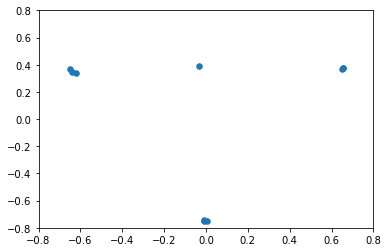

In [5]:
# Petersen graph
A = np.array([
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0]])
A = torch.tensor(A,dtype=torch.float32) #-torch.eye(10)
N = A.shape[0] # Number of vertices
n_steps = 800
c = 3
beta=0.02 # Temperature

# Minimize loss
vals = []
x = torch.randn((N,c),requires_grad=True) # Logits
x.data = 10*x.data
optimizer = torch.optim.Adam([x], lr=0.1)
points =[]
losses = []

for step in range(n_steps):
    optimizer.zero_grad()
    p = torch.softmax(beta*x,dim=1) # probabilities
    points.append(p.detach())
    loss = torch.sum(A*(p@p.t())) # Covariance matrix
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

# print("Loss: ",loss.item())
# print("Independence: ",torch.sum(A*(p@p.t())).item())
# print("")

coloring = torch.softmax(20*x,dim=1)
# print(p)
# print(p>0.5)
val = torch.sum(A*(coloring@coloring.t())).item()
print(val)
points = torch.stack(points).numpy()
R = np.array([[1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)],
              [1/np.sqrt(2),-1/np.sqrt(2),0],
              [1/np.sqrt(6),1/np.sqrt(6),-2/np.sqrt(6)]])

in_plane = (points@R.T)[:,:,1:] #-np.array([1]+[0]*(c-1))/np.sqrt(c)

# Animate points of in_plane as moving scatter plot
fig, ax = plt.subplots()
scat = ax.scatter(in_plane[0,:,0], in_plane[0,:,1],s=30)

ax.set_xlim([-0.8,0.8])
ax.set_ylim([-0.8,0.8])

def update(frame_number):
    scat.set_offsets(in_plane[frame_number])

ani = animation.FuncAnimation(fig, update, frames=n_steps, interval=50)
ani.save('test.gif', writer='imagemagick', fps=30)







Here's another version. Rather than using softmax, we just normalize the vectors at each step while trying to push the angle between adjacent vertices towards 90. The probability will be defined by squaring all the entries. 

In [13]:
# Petersen graph
A = np.array([
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0]])
A = torch.tensor(A,dtype=torch.float32) #-torch.eye(10)
N = A.shape[0] # Number of vertices
n_steps = 800
c = 2
beta=0.02 # Temperature

# Minimize loss
vals = []

# Init x
x = torch.randn((N,c),requires_grad=True) # Logits
x.data = torch.nn.functional.normalize(x.data, p=2, dim=1)

optimizer = torch.optim.Adam([x], lr=0.1)
# optimizer = torch.optim.SGD([x], lr=0.005)
points =[]
losses = []

for step in range(n_steps):
    optimizer.zero_grad()
    
    y = x**2
    # p = y/torch.sum(y,dim=1,keepdim=True) # probabilities
    total = torch.sum(y,dim=1,keepdim=True)
    # print(total)
    p = y#/total
    # p = torch.nn.functional.normalize(y, p=1, dim=1)

    points.append(p.detach())
    loss = torch.sum(A*(p@p.t())) # Covariance matrix
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    x.data = torch.nn.functional.normalize(x.data, p=2, dim=1)

# print("Loss: ",loss.item())
# print("Independence: ",torch.sum(A*(p@p.t())).item())
# print("")

# coloring = x**2 #torch.softmax(20*x,dim=1)
coloring = torch.softmax(10*p,dim=1)

# print(p)
# print(p>0.5)
val = torch.sum(A*(coloring@coloring.t())).item()
print(val)


# points = torch.stack(points).numpy()
# R = np.array([[1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)],
#               [1/np.sqrt(2),-1/np.sqrt(2),0],
#               [1/np.sqrt(6),1/np.sqrt(6),-2/np.sqrt(6)]])

# in_plane = (points@R.T)[:,:,1:] #-np.array([1]+[0]*(c-1))/np.sqrt(c)

# # Animate points of in_plane as moving scatter plot

# fig, ax = plt.subplots()
# scat = ax.scatter(in_plane[0,:,0], in_plane[0,:,1],s=30)

# ax.set_xlim([-0.8,0.8])
# ax.set_ylim([-0.9,0.6])

# def update(frame_number):
#     scat.set_offsets(in_plane[frame_number])

# ani = animation.FuncAnimation(fig, update, frames=n_steps, interval=50)
# ani.save('test.gif', writer='imagemagick', fps=30)
# plt.close(fig)


6.017468452453613


In [1]:
from math import comb as binom

def chromatic_polynomial(x,n,m,g,k):
    out = 0
    for i in range(n+1):
        if i<g-1:
            out += (-x)**i*binom(m,i)
        else:
            out += (-x)**i*(binom(m,g-1)-k)
    return out

def chromatic_polynomial2(x,n,m,g,k):
    out = 0
    for i in range(g):
        if i<g-1:
            out += (x**(n-i))*(-1)**i*binom(m,i)
    out += x^(n-g+1)
    return out

In [2]:
import sympy as sp
import itertools
v=4
vals = []
for i in range(v):
    for j in range(i):
        z = i^2+j^2 + i*j 
        z = z%v
        vals.append(z)
print(len(set(vals)))

# Write a program that enumerates all symmetric polynomials in 2 variables of degree at most 3.
x, y = sp.symbols('x y')
polynomials = []

# simple_polynomials = [x**i * y**j + x**j * y**i for i in range(4) for j in range(i+1)]
# Get elementary symmetric polynomials in x and y
max_degree = 3
simple_polynomials = []
for i in range(max_degree+1):
    for j in range(i + 1):
        if i == j:
            simple_polynomials.append(x**i * y**j)
        else:
            simple_polynomials.append(x**i * y**j + x**j * y**i)

# Get elementary symmetric polynomials in x and y
n = len(simple_polynomials)
# Enumerate all n-tuples of numbers from 0 to v-1
# Enumerate all n-tuples of numbers from 0 to v-1
n_tuples = list(itertools.product(range(v), repeat=4))
print(n_tuples)

print(simple_polynomials)



        

3
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 1, 3), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 1, 2, 3), (0, 1, 3, 0), (0, 1, 3, 1), (0, 1, 3, 2), (0, 1, 3, 3), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 0, 3), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 1, 3), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (0, 2, 2, 3), (0, 2, 3, 0), (0, 2, 3, 1), (0, 2, 3, 2), (0, 2, 3, 3), (0, 3, 0, 0), (0, 3, 0, 1), (0, 3, 0, 2), (0, 3, 0, 3), (0, 3, 1, 0), (0, 3, 1, 1), (0, 3, 1, 2), (0, 3, 1, 3), (0, 3, 2, 0), (0, 3, 2, 1), (0, 3, 2, 2), (0, 3, 2, 3), (0, 3, 3, 0), (0, 3, 3, 1), (0, 3, 3, 2), (0, 3, 3, 3), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 2), (1, 0, 0, 3), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 2), (1,